<a href="https://colab.research.google.com/github/kruttikajain/Targetted-Abusive_Language_Online/blob/master/prediciton2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abusive Language Online 

Predition1: predict OFF/NOT

* Upload it each time: Dataset: [data](http://demo.clab.cs.cmu.edu/ethical_nlp2019/homeworks/hw3/hw3.html)


1.   train.tsv
2.   dev.tsv
3.   test.tsv

* Need manually add log.txt
* Mount drive to load GloVe embeddings




# Import useful lib

In [0]:
import os
import sys
from logging import handlers
from pathlib import Path
import logging
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
import random 

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, CuDNNLSTM, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline 
import matplotlib.pyplot as plt

# Data proprecessing

## mounting drive

In [56]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [57]:
!pwd

/content


In [80]:
# Clone github repository setup
# import join used to join ROOT path and MY_GOOGLE_DRIVE_PATH
from os.path import join  

# path to your project on Google Drive
MY_GOOGLE_DRIVE_PATH = '' 
# replace with your Github username 
GIT_USERNAME = "kruttikajain" 
# definitely replace with your
GIT_TOKEN = "5fae1c9f18e3a0c680bf35e9ef63c72308ef2b4c"  
# Replace with your github repository in this case we want 
# to clone deep-learning-v2-pytorch repository
GIT_REPOSITORY = "Targetted-Abusive_Language_Online" 

# PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH)

'''
only this line should be modify
'''
PROJECT_PATH = './gdrive/My Drive/Colab Notebooks/246Project'

# It's good to print out the value if you are not sure 
print("PROJECT_PATH: ", PROJECT_PATH)   

# In case we haven't created the folder already; we will create a folder in the project path 
!mkdir "{PROJECT_PATH}"    

#GIT_PATH = "https://{GIT_TOKEN}@github.com/{GIT_USERNAME}/{GIT_REPOSITORY}.git" this return 400 Bad Request for me
GIT_PATH = "https://" + GIT_TOKEN + "@github.com/" + GIT_USERNAME + "/" + GIT_REPOSITORY + ".git"
print("GIT_PATH: ", GIT_PATH)

PROJECT_PATH:  ./gdrive/My Drive/Colab Notebooks/246Project
mkdir: cannot create directory ‘./gdrive/My Drive/Colab Notebooks/246Project’: File exists
GIT_PATH:  https://5fae1c9f18e3a0c680bf35e9ef63c72308ef2b4c@github.com/kruttikajain/Targetted-Abusive_Language_Online.git


## Prepare logging file

In [81]:
def init_logger(log_file):
    if not os.path.exists(log_file):
        os.makedirs(os.path.dirname(log_file))

    log = logging.getLogger('')
    log.setLevel(logging.INFO)
    output_format = logging.Formatter(fmt='%(asctime)s %(levelname)-8s %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
    std_out_handler = logging.StreamHandler(sys.stdout)
    std_out_handler.setFormatter(output_format)
    logging.getLogger().addHandler(std_out_handler)
    file_handler = logging.handlers.RotatingFileHandler(log_file, maxBytes=(1048576*5), backupCount=7)
    file_handler.setFormatter(output_format)
    logging.getLogger().addHandler(file_handler)

init_logger(PROJECT_PATH + '/log.txt')
logging.info('=============start2=================')
logging.info('logging file prepared...')

2020-05-17 18:22:34 INFO     =============start2=================
2020-05-17 18:22:34 INFO     =============start2=================
2020-05-17 18:22:34 INFO     =============start2=================
2020-05-17 18:22:34 INFO     =============start2=================
2020-05-17 18:22:34 INFO     =============start2=================
2020-05-17 18:22:34 INFO     logging file prepared...
2020-05-17 18:22:34 INFO     logging file prepared...
2020-05-17 18:22:34 INFO     logging file prepared...
2020-05-17 18:22:34 INFO     logging file prepared...
2020-05-17 18:22:34 INFO     logging file prepared...


## load data

In [82]:
def load_data():
    logging.info('loading the dataset...')
    train_df = pd.read_csv(PROJECT_PATH + '/project_data/train.tsv', sep="\t")
    val_df = pd.read_csv(PROJECT_PATH + '/project_data/dev.tsv', sep="\t")
    test_df = pd.read_csv(PROJECT_PATH + '/project_data/test.tsv', sep="\t")
    
    # shape of df, column names
    logging.info('Train shape : ' + str(train_df.shape)) # 'text', 'label', 'category'
    logging.info('Val shape: ' + str(val_df.shape))
    logging.info('Test shape: ' + str(test_df.shape))
    
    logging.info('train_df.columns: ' + train_df.columns)
    logging.info('val_df.columns: ' + val_df.columns)
    logging.info('test_df.columns: ' + test_df.columns)

    return train_df, val_df, test_df

train_df, val_df, test_df = load_data()

2020-05-17 18:22:37 INFO     loading the dataset...
2020-05-17 18:22:37 INFO     loading the dataset...
2020-05-17 18:22:37 INFO     loading the dataset...
2020-05-17 18:22:37 INFO     loading the dataset...
2020-05-17 18:22:37 INFO     loading the dataset...
2020-05-17 18:22:37 INFO     Train shape : (10592, 3)
2020-05-17 18:22:37 INFO     Train shape : (10592, 3)
2020-05-17 18:22:37 INFO     Train shape : (10592, 3)
2020-05-17 18:22:37 INFO     Train shape : (10592, 3)
2020-05-17 18:22:37 INFO     Train shape : (10592, 3)
2020-05-17 18:22:37 INFO     Val shape: (1324, 3)
2020-05-17 18:22:37 INFO     Val shape: (1324, 3)
2020-05-17 18:22:37 INFO     Val shape: (1324, 3)
2020-05-17 18:22:37 INFO     Val shape: (1324, 3)
2020-05-17 18:22:37 INFO     Val shape: (1324, 3)
2020-05-17 18:22:37 INFO     Test shape: (1324, 1)
2020-05-17 18:22:37 INFO     Test shape: (1324, 1)
2020-05-17 18:22:37 INFO     Test shape: (1324, 1)
2020-05-17 18:22:37 INFO     Test shape: (1324, 1)
2020-05-17 18:22

In [83]:
train_df.head(40)

,text,label,category
0,@USER @USER You are an embarrassing citizen!!,OFF,TIN
1,@USER Seems hard to believe that you stood next to a guy wearing those shorts and didn't masturbate but I'll take your word for it,OFF,TIN
2,@USER @USER @USER Wow !!! no wonder the Liberals only got worse as a party of bullies to women...??? no accountability.,OFF,TIN
3,@USER @USER And not all idiots grandstands like he did,OFF,TIN
4,@USER Bring on the hypocrite gungrabber. MAGA,OFF,TIN
5,@USER bitch call me.,OFF,TIN
6,@USER The only thing i didn’t agree with was the match point he was following the rules i think this was more about her sex honestly all she did was call him a thief and he penalized her shit was wack,OFF,TIN
7,@USER I second this they’re fucking nuts,OFF,TIN
8,@USER Eric Holder a major embarrassment to law enforcement. @USER you did nothing about those innocent black males killed in those streets. One sorry black brother.,OFF,TIN
9,@USER @USER because the average American has $500 lying around to buy a new Glock. more likely Mr. Antifa will be using his unemployment check to purchase some dental work or a casket.,OFF,TIN


**Attributes in data:**


***Trainning data:***  (10592, 3) \\

* **text:** \\
tweet content

* **label:** \\
1.   (NOT) Not Offensive - This post does not contain offense or profanity
2.   (OFF) Offensive - This post contains offensive language or a targeted (veiled or direct) offense

* **category:** (if label is 'OFF') \\
1.   (TIN) Targeted Insult and Threats - A post containing an insult or threat to an individual, a group, or others
2.   (UNT) Untargeted - A post containing non-targeted profanity and swearing.

***Validation data:***  (1324, 3) \\

***Testing data***:  'text' (1324, 1) \\
* **text**

## Data cleaning

In [0]:
def data_cleaning(train_df, val_df, test_df):
    # shuffle data
    train_df = train_df.sample(frac=1, random_state=2020).reset_index(drop=True)
    
    # lo lowercae
    train_df['text'] = train_df['text'].str.lower()
    val_df['text'] = val_df['text'].str.lower()
    test_df['text'] = test_df['text'].str.lower()

    # delete "noise words"
    noise = ["url","user","@","&amp;","#","-",'.',"!","?","rt","dm","retweet","rt","dm"]
    for WORD in noise:
        train_df['text'] = train_df['text'].str.replace(WORD, '')
        val_df['text'] = val_df['text'].str.replace(WORD, '')
        test_df['text'] = test_df['text'].str.replace(WORD, '')

    # change label to 0/a
    train_df['label'] = train_df['label'].map({'OFF': 1, 'NOT': 0})
    val_df['label'] = val_df['label'].map({'OFF': 1, 'NOT': 0})

    # one-hot encoding of category
    #train_df = pd.concat([train_df,pd.get_dummies(train_df['category'], prefix='category')],axis=1)
    #train_df.drop(['category'],axis=1, inplace=True)
    
    #val_df = pd.concat([val_df,pd.get_dummies(val_df['category'], prefix='category')],axis=1)
    #val_df.drop(['category'],axis=1, inplace=True)
  
    train_df['category'] = train_df['category'].map({'TIN': 1, 'UNT': 0},na_action='ignore')
    val_df['category'] = val_df['category'].map({'TIN': 1, 'UNT': 0}, na_action='ignore')
    return train_df, val_df, test_df

train_df, val_df, test_df = data_cleaning(train_df, val_df, test_df)


In [0]:
test

In [92]:
val_df.head(10)

,text,label,category
0,she should ask a few native americans what their take on this is,1,0.0
1,go home you’re drunk maga trump2020 👊🇺🇸👊,1,1.0
2,amazon is investigating chinese employees who are selling internal data to thirdpay sellers looking for an edge in the competitive marketplace amazon maga kag china tcot,0,NaN
3,"someone should'vetaken"" this piece of shit to a volcano 😂""",1,0.0
4,obama wanted liberals illegals to move into red states,0,NaN
5,liberals are all kookoo,1,1.0
6,oh noes tough shit,1,0.0
7,was literally just talking about this lol all mass shootings like that have been set ups it’s propaganda used to divide us on major issues like gun control and terrorism,1,1.0
8,buy more icecream,0,NaN
9,canada doesn’t need another cuck we already have enough looneyleft liberals f**king up our great country qproofs trudeaumustgo,1,1.0


In [0]:
train_df=train_df[train_df.label !=0]

In [94]:
train_df.head(10)

,text,label,category
0,didn't this trashy thing sleep her way to the top with married men,1,1.0
1,gfy the nfl should get no protection from the policeand no suppo from our militarythe league will slowly die on this road of shame,1,1.0
10,👀 sitting here thinking he has a killer porn stache,1,0.0
13,all trump's and pense 2020 merch is being made is china and not the usa maga votethemout2018 trumpsarmy,1,1.0
16,gun control now enough is enough,1,0.0
17,you're full of s*** it's the liberals paid by soros who are doing those things,1,1.0
20,liberals are addicted to fake news chris is their dope man,1,1.0
23,any texan that would grant automatic citizenship to illegal immigrants should never be elected,1,1.0
24,yeah he’s very immature can dish out criticism while crying and blocking instead of accepting any it’s cool folks can see him for who he is mostly,1,1.0
26,yoo our dogs should totally fuck,1,1.0


In [0]:
val_df=val_df[val_df.label !=0]


In [96]:
val_df.head(10)

,text,label,category
0,she should ask a few native americans what their take on this is,1,0.0
1,go home you’re drunk maga trump2020 👊🇺🇸👊,1,1.0
3,"someone should'vetaken"" this piece of shit to a volcano 😂""",1,0.0
5,liberals are all kookoo,1,1.0
6,oh noes tough shit,1,0.0
7,was literally just talking about this lol all mass shootings like that have been set ups it’s propaganda used to divide us on major issues like gun control and terrorism,1,1.0
9,canada doesn’t need another cuck we already have enough looneyleft liberals f**king up our great country qproofs trudeaumustgo,1,1.0
12,you are a lying corrupt traitor nobody wants to hear anymore of your lies deepstatecorruption,1,1.0
19,gun control that is all these kids are asking for,1,1.0
20,lol throwing the bullshit flag on such nonsense putuporshutup kavanaugh maga callthevotealready,1,1.0


In [97]:
test_df.head()

,text
0,liberals got to crap all over everything
1,dint pay any attention to hershe's yet to say anything of interest meme jerk
2,the liberals same old playbook it is so old yawn
3,all you do is lie all congress does us lie maga
4,never nigga 💀💀


Check the content of abusive text

In [98]:
abusive_df = train_df.loc[train_df['label'] == 1]
# pd.set_option('display.max_rows', None)
# pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
abusive_df['text'].head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


0      didn't this trashy thing sleep her way to the top with married men                                                                 
1       gfy the nfl should get no protection from the policeand no suppo from our militarythe league will slowly die on this road of shame
10     👀 sitting here thinking he has a killer porn stache                                                                                
13    all trump's and pense 2020 merch is being made is china and not the usa    maga    votethemout2018  trumpsarmy                      
16     gun control now enough is enough                                                                                                   
Name: text, dtype: object

## Data distribution and visualization 

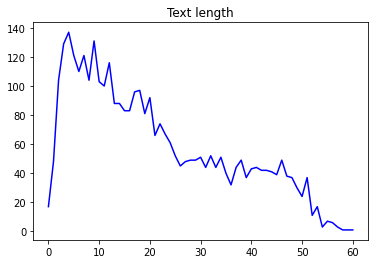

2020-05-17 19:38:20 INFO     number of label = 1 : 3520
2020-05-17 19:38:20 INFO     number of label = 1 : 3520
2020-05-17 19:38:20 INFO     number of label = 1 : 3520
2020-05-17 19:38:20 INFO     number of label = 1 : 3520
2020-05-17 19:38:20 INFO     number of label = 1 : 3520


KeyError: ignored

In [99]:
# count how many letters in a sentence
def label_distribution(train_df):
    #  length of text
    count = train_df['text'].str.split().apply(len).value_counts()
    count.sort_index(inplace=True)
    count.index = count.index.astype(str) + ' words:'
    # logging.info(count[0:5])
    # logging.info(count[-5:])
    plt.plot(range(len(count)), count, color='blue')
    plt.title("Text length")
    plt.show()
    # label distribution
    logging.info('number of label = 1 : ' + str((train_df['label'] != 0).sum()))
    logging.info('number of category_TIN = 1: ' + str((train_df['category_TIN'] != 0).sum()))
    logging.info('number of category_UNT = 1: ' + str((train_df['category_UNT'] != 0).sum()))

    # plot histogram
    train_df['label'].plot.hist(bins=2, title='label distribution')
    plt.show()

label_distribution(train_df)


**Property of dataset**

*   **Length of text:** [2, 60]

*   **label:** 
1.   label = 0: 7072
2.   label = 1: 3520

* Among label = 1: \\
1.   category_TIN = 1: 3089
2.   category_UNT = 1: 431



Word cloud

In [0]:
# word cloud
normal_df = train_df.loc[train_df.label == 0]
abusive_df = train_df.loc[train_df.label == 1]

normal_text_array = np.array(normal_df['text'])
abusive_text_array = np.array(abusive_df['text'])

normal_text = ''.join(normal_text_array)
abusive_text = ''.join(abusive_text_array)

logging.info("convert to text finished")

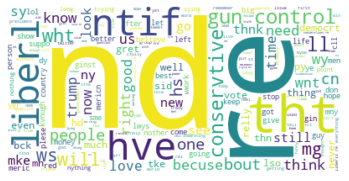

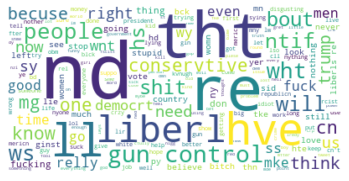

In [0]:
# normal
wordcloud = WordCloud(background_color="white").generate(normal_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# abusive
wordcloud = WordCloud(background_color="white").generate(abusive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Delete some common words

In [0]:
normal_text = normal_text.replace('liberal','',1000).replace('people','',1000).replace('will','',1000)
abusive_text = abusive_text.replace('liberal','',1000).replace('people','',1000).replace('will','',1000)

In [102]:
# normal
wordcloud = WordCloud(background_color="white").generate(normal_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# abusive
wordcloud = WordCloud(background_color="white").generate(abusive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

ValueError: ignored

# Split data to X and y

Split data to X and y

In [103]:
def split_train_val(train_df, val_df, test_df):
    logging.info('splitting X and y ...')
    train_X = train_df["text"].fillna("_na_").values
    val_X = val_df["text"].fillna("_na_").values
    test_X = test_df["text"].fillna("_na_").values

    train_y = train_df['category'].values
    val_y = val_df['category'].values

    logging.info('finished splitting X and y')
    return train_X, val_X, test_X, train_y, val_y

train_X, val_X, test_X, train_y, val_y = split_train_val(train_df, val_df, test_df)

2020-05-17 19:40:02 INFO     splitting X and y ...
2020-05-17 19:40:02 INFO     splitting X and y ...
2020-05-17 19:40:02 INFO     splitting X and y ...
2020-05-17 19:40:02 INFO     splitting X and y ...
2020-05-17 19:40:02 INFO     splitting X and y ...
2020-05-17 19:40:02 INFO     finished splitting X and y
2020-05-17 19:40:02 INFO     finished splitting X and y
2020-05-17 19:40:02 INFO     finished splitting X and y
2020-05-17 19:40:02 INFO     finished splitting X and y
2020-05-17 19:40:02 INFO     finished splitting X and y


In [104]:
print(train_X.shape, train_y.shape)
print(val_X.shape, val_y.shape)

(3520,) (3520,)
(440,) (440,)


Tokenize and padding each sentence, split datafram to attributes and labels

In [105]:
# each word embedding to 300 dimension
embed_size = 300
# count of vocabulary words
max_features = 50000
# length of each sentences
max_len = 70

def token_sentence(train_X, val_X, test_X ):
    logging.info('tokenizing sentence...')
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(train_X))
    train_X = tokenizer.texts_to_sequences(train_X)
    val_X = tokenizer.texts_to_sequences(val_X)
    test_X = tokenizer.texts_to_sequences(test_X)

    logging.info('padding sentence...')
    train_X = pad_sequences(train_X, maxlen=max_len)
    val_X = pad_sequences(val_X, maxlen=max_len)
    test_X = pad_sequences(test_X, maxlen=max_len)

    logging.info('all finished...')
    return train_X, val_X, test_X, tokenizer

train_X, val_X, test_X, tokenizer = token_sentence(train_X, val_X, test_X)


2020-05-17 19:40:23 INFO     tokenizing sentence...
2020-05-17 19:40:23 INFO     tokenizing sentence...
2020-05-17 19:40:23 INFO     tokenizing sentence...
2020-05-17 19:40:23 INFO     tokenizing sentence...
2020-05-17 19:40:23 INFO     tokenizing sentence...
2020-05-17 19:40:23 INFO     padding sentence...
2020-05-17 19:40:23 INFO     padding sentence...
2020-05-17 19:40:23 INFO     padding sentence...
2020-05-17 19:40:23 INFO     padding sentence...
2020-05-17 19:40:23 INFO     padding sentence...
2020-05-17 19:40:23 INFO     all finished...
2020-05-17 19:40:23 INFO     all finished...
2020-05-17 19:40:23 INFO     all finished...
2020-05-17 19:40:23 INFO     all finished...
2020-05-17 19:40:23 INFO     all finished...


In [106]:
train_X.shape

(3520, 70)

# Train model

## Model1: base line

In [0]:
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

# precision is the ratio tp / (tp + fp)
# recall is the ratio tp / (tp + fn)
# F1 = 2 * (precision * recall) / (precision + recall)

### Decision tree

In [0]:
def dt_model(train_X, train_y, val_X, cal_y):
    dt_clf = tree.DecisionTreeClassifier()
    dt_clf = dt_clf.fit(train_X, train_y)
    pred_val_y = dt_clf.predict(val_X).reshape(-1,1)
    
    tn, fp, fn, tp = confusion_matrix(pred_val_y, val_y).ravel()
    print('tn', tn, 'fp', fp, 'fn', fn, 'tp', tp)

    dt_acc = accuracy_score(pred_val_y, val_y)
    dt_precision = precision_score(pred_val_y, val_y)
    dt_recall = recall_score(pred_val_y, val_y)
    dt_f1_score = f1_score(pred_val_y, val_y)
    return dt_acc, dt_precision, dt_recall, dt_f1_score 

In [109]:
dt_acc, dt_precision, dt_recall, dt_f1_score= dt_model(train_X, train_y, val_X, val_y)
print('dt_acc: ', dt_acc, 'dt_precision: ', dt_precision, 'dt_recall: ',dt_recall,', dt_f1_score: ',  dt_f1_score)

tn 9 fp 48 fn 35 tp 348
dt_acc:  0.8113636363636364 dt_precision:  0.8787878787878788 dt_recall:  0.9086161879895561 , dt_f1_score:  0.8934531450577664


### LogisticRegression

In [0]:
def lr_model(train_X, train_y, val_X, cal_y):
    lr_clf = LogisticRegression(random_state=0, max_iter=4000).fit(train_X, train_y)
    pred_val_y = lr_clf.predict(val_X).reshape(-1,1)

    tn, fp, fn, tp = confusion_matrix(pred_val_y, val_y).ravel()
    print('tn', tn, 'fp', fp, 'fn', fn, 'tp', tp)

    lr_acc = accuracy_score(pred_val_y, val_y)
    lr_precision = precision_score(pred_val_y, val_y)
    lr_recall = recall_score(pred_val_y, val_y)
    lr_f1_score = f1_score(pred_val_y, val_y)
    return lr_acc, lr_precision, lr_recall, lr_f1_score

In [0]:
lr_acc, lr_precision, lr_recall, lr_f1_score = lr_model(train_X, train_y, val_X, val_y)
print('lr_precision', lr_precision, 'lr_recall', lr_recall)
print('lr_acc: ', lr_acc, ', lr_f1_score: ',  lr_f1_score)

tn 881 fp 439 fn 3 tp 1
lr_precision 0.0022727272727272726 lr_recall 0.25
lr_acc:  0.6661631419939577 , lr_f1_score:  0.0045045045045045045


### GaussianNB

In [0]:
def gNB_model(train_X, train_y, val_X, cal_y):
    gNB_clf = GaussianNB()
    gNB_clf = gNB_clf.fit(train_X, train_y)
    pred_val_y = gNB_clf.predict(val_X).reshape(-1,1)

    tn, fp, fn, tp = confusion_matrix(pred_val_y, val_y).ravel()
    print('tn', tn, 'fp', fp, 'fn', fn, 'tp', tp)

    gNB_acc = accuracy_score(pred_val_y, val_y)
    gNB_precision = precision_score(pred_val_y, val_y)
    gNB_recall = recall_score(pred_val_y, val_y)
    gNB_f1_score = f1_score(pred_val_y, val_y)
    return gNB_acc, gNB_precision, gNB_recall, gNB_f1_score

In [0]:
gNB_acc, gNB_precision, gNB_recall, gNB_f1_score = gNB_model(train_X, train_y, val_X, val_y)
print('gNB_acc: ', gNB_acc, 'gNB_precision: ', gNB_precision, 'gNB_recall:', gNB_recall, 'gNB_f1_score: ',  gNB_f1_score)

tn 1 fp 1 fn 883 tp 439
gNB_acc:  0.3323262839879154 gNB_precision:  0.9977272727272727 gNB_recall: 0.3320726172465961 gNB_f1_score:  0.49829738933030654


## Model2 : LSTM + Without Pretrained Embeddings:

In [0]:
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential()

# Add an Embedding layer expecting input vocab of size 50000, and
# output embedding dimension of size 300.
model.add(layers.Embedding(input_dim=50000, output_dim=300))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))
model.add(layers.Dense(10,activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         15000000  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 15,220,949
Trainable params: 15,220,949
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
callbacks = EarlyStopping(monitor='val_loss', min_delta=0, patience = 2)
history = model.fit(train_X, 
                    train_y, 
                    batch_size=512, 
                    epochs=14, 
                    validation_data=(val_X, val_y),
                    callbacks=callbacks
                    )

Epoch 1/14
21/21 [==============================] - 26s 1s/step - loss: 0.6411 - accuracy: 0.6634 - val_loss: 0.6224 - val_accuracy: 0.6677
Epoch 2/14
21/21 [==============================] - 25s 1s/step - loss: 0.5697 - accuracy: 0.6859 - val_loss: 0.5799 - val_accuracy: 0.6903
Epoch 3/14
21/21 [==============================] - 25s 1s/step - loss: 0.4241 - accuracy: 0.8266 - val_loss: 0.5858 - val_accuracy: 0.7236
Epoch 4/14
21/21 [==============================] - 25s 1s/step - loss: 0.2720 - accuracy: 0.9041 - val_loss: 0.6918 - val_accuracy: 0.6971


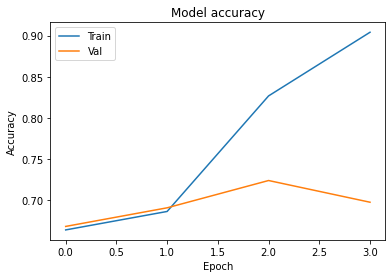

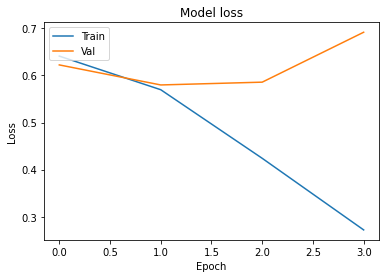

In [0]:
# plot history
# Plot training & validation accuracy values
import matplotlib.pyplot as plt 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [0]:
pred_noemb_val_y = model.predict([val_X], batch_size=1024, verbose=1)
print(pred_noemb_val_y)

2/2 [==============================] - 0s 121ms/step
[[0.01626626]
 [0.44740385]
 [0.07183039]
 ...
 [0.10910358]
 [0.88955307]
 [0.35217392]]


In [0]:
# validation the model(confusion matrix)
def rnn_confusion_matrix(pred_noemb_val_y, val_y):
    pred_val_y = pred_noemb_val_y > 0.5
    tn, fp, fn, tp = confusion_matrix(pred_val_y, val_y).ravel()
    print('tn', tn, 'fp', fp, 'fn', fn, 'tp', tp)

    lstm_acc = accuracy_score(pred_val_y, val_y)
    lstm_precision = precision_score(pred_val_y, val_y)
    lstm_recall = recall_score(pred_val_y, val_y)
    lstm_f1_score = f1_score(pred_val_y, val_y)
    return lstm_acc, lstm_precision, lstm_recall, lstm_f1_score

lstm_acc, lstm_precision, lstm_recall, lstm_f1_score = rnn_confusion_matrix(pred_noemb_val_y, val_y)
print('lstm_acc: ',lstm_acc, ', lstm_precision: ', lstm_precision, ', lstm_recall: ', lstm_recall, ', lstm_f1_score', lstm_f1_score)

tn 676 fp 193 fn 208 tp 247
lstm_acc:  0.697129909365559 lstm_precision:  0.5613636363636364 lstm_recall:  0.5428571428571428 lstm_f1_score 0.5519553072625699


In [0]:
# validation the model(f1-score)

threshes=[]
f1_scores=[]
accuracy_scores=[]
for thresh in np.arange(0.1, 0.801, 0.01):
    thresh = np.round(thresh, 2)
    threshes.append(thresh)
    # logging.info("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))))
    f1_scores.append(metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int)))
    # logging.info("Accuracy at threshold {0} is {1}".format(thresh, metrics.accuracy_score(val_y, (pred_noemb_val_y>thresh).astype(int))))
    accuracy_scores.append(metrics.accuracy_score(val_y, (pred_noemb_val_y>thresh).astype(int)))


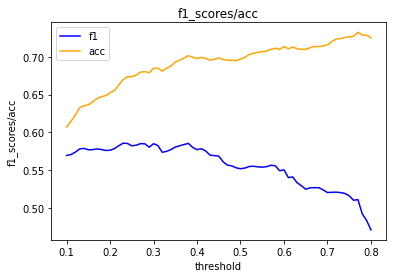

In [0]:
# plot two measures
plt.plot(threshes, f1_scores, color='blue', label='f1')
plt.plot(threshes, accuracy_scores, color='orange', label='acc')
plt.title('f1_scores/acc')
plt.ylabel('f1_scores/acc')
plt.xlabel('threshold')
plt.legend()
plt.show()

## Model3: LSTM + Pretrained embeddings

Embeddings:
glove.840B.300d - https://nlp.stanford.edu/projects/glove/
paragram_300_sl999 - https://cogcomp.org/page/resource_view/106

It will take several minutes to load this 5G file. Be patient.. 





In [0]:
import io
embeddings_index = {}
logging.info("Loading Glove Model")
with io.open(PROJECT_PATH +'/glove.840B.300d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = ''.join(values[:-300])
        coefs = np.asarray(values[-300:], dtype='float32')
        embeddings_index[word] = coefs
logging.info("Loading Glove Model Done")

2020-05-10 06:08:53 INFO     Loading Glove Model
2020-05-10 06:12:03 INFO     Loading Glove Model Done


In [0]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

print(all_embs.shape, emb_mean, emb_std, embed_size )

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


(2195893, 300) -0.005839112 0.48782477 300


In [0]:
word_index = tokenizer.word_index
len(word_index)

19626

In [0]:
nb_words = min(max_features, 1 + len(word_index))
nb_words

19627

In [0]:
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
embedding_matrix.shape

(19627, 300)

In [0]:
for word, i in word_index.items(): 
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(19627, 300)


In [0]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.initializers import Constant

model = tf.keras.Sequential()
model.add(layers.Embedding(nb_words,
                            300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))
model.add(layers.LSTM(128))
model.add(layers.Dense(10,activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 70, 300)           5888100   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 6,109,049
Trainable params: 220,949
Non-trainable params: 5,888,100
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks = EarlyStopping(monitor='val_loss', min_delta=0, patience = 2)

history = model.fit(train_X, 
                    train_y, 
                    batch_size=512, 
                    epochs=15, 
                    validation_data=(val_X, val_y),
                    callbacks=callbacks
                    )

Epoch 1/15
21/21 [==============================] - 18s 846ms/step - loss: 0.5992 - accuracy: 0.6720 - val_loss: 0.5743 - val_accuracy: 0.6790
Epoch 2/15
21/21 [==============================] - 17s 825ms/step - loss: 0.5319 - accuracy: 0.7325 - val_loss: 0.5249 - val_accuracy: 0.7424
Epoch 3/15
21/21 [==============================] - 17s 819ms/step - loss: 0.4925 - accuracy: 0.7644 - val_loss: 0.4994 - val_accuracy: 0.7651
Epoch 4/15
21/21 [==============================] - 17s 819ms/step - loss: 0.4800 - accuracy: 0.7754 - val_loss: 0.4918 - val_accuracy: 0.7749
Epoch 5/15
21/21 [==============================] - 17s 819ms/step - loss: 0.4594 - accuracy: 0.7852 - val_loss: 0.4943 - val_accuracy: 0.7795
Epoch 6/15
21/21 [==============================] - 17s 821ms/step - loss: 0.4412 - accuracy: 0.7959 - val_loss: 0.4886 - val_accuracy: 0.7825
Epoch 7/15
21/21 [==============================] - 17s 819ms/step - loss: 0.4256 - accuracy: 0.8050 - val_loss: 0.4869 - val_accuracy: 0.7576

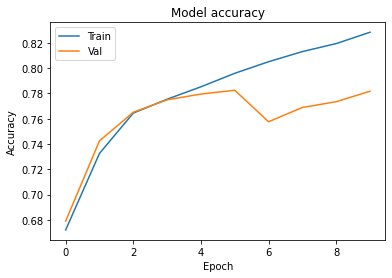

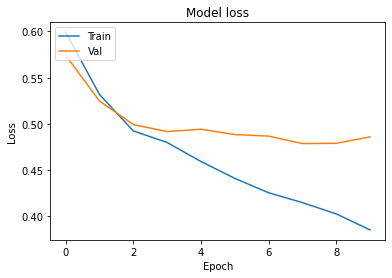

In [0]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [0]:
# validation the model(f1-score)
pred_noemb_val_y = model.predict([val_X], batch_size=1024, verbose=1)
print(pred_noemb_val_y)
threshes=[]
f1_scores=[]
accuracy_scores=[]
for thresh in np.arange(0.1, 0.801, 0.01):
    thresh = np.round(thresh, 2)
    threshes.append(thresh)
    logging.info("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))))
    f1_scores.append(metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int)))
    logging.info("Accuracy at threshold {0} is {1}".format(thresh, metrics.accuracy_score(val_y, (pred_noemb_val_y>thresh).astype(int))))
    accuracy_scores.append(metrics.accuracy_score(val_y, (pred_noemb_val_y>thresh).astype(int)))

2/2 [==============================] - 0s 117ms/step
[[0.10481516]
 [0.38649255]
 [0.01356268]
 ...
 [0.3059154 ]
 [0.30343664]
 [0.0591504 ]]
2020-05-10 06:16:20 INFO     F1 score at threshold 0.1 is 0.6162332545311269
2020-05-10 06:16:20 INFO     Accuracy at threshold 0.1 is 0.6321752265861027
2020-05-10 06:16:20 INFO     F1 score at threshold 0.11 is 0.6193548387096774
2020-05-10 06:16:20 INFO     Accuracy at threshold 0.11 is 0.6435045317220544
2020-05-10 06:16:20 INFO     F1 score at threshold 0.12 is 0.6238683127572017
2020-05-10 06:16:20 INFO     Accuracy at threshold 0.12 is 0.654833836858006
2020-05-10 06:16:20 INFO     F1 score at threshold 0.13 is 0.6282372598162071
2020-05-10 06:16:20 INFO     Accuracy at threshold 0.13 is 0.6638972809667674
2020-05-10 06:16:20 INFO     F1 score at threshold 0.14 is 0.629881154499151
2020-05-10 06:16:20 INFO     Accuracy at threshold 0.14 is 0.6706948640483383
2020-05-10 06:16:20 INFO     F1 score at threshold 0.15 is 0.6335616438356165
202

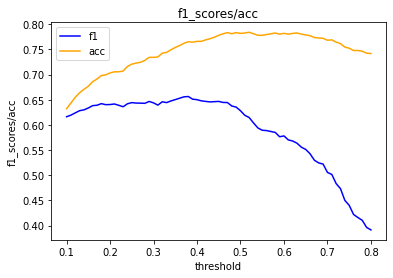

In [0]:
# plot two measures
plt.plot(threshes, f1_scores, color='blue', label='f1')
plt.plot(threshes, accuracy_scores, color='orange', label='acc')
plt.title('f1_scores/acc')
plt.ylabel('f1_scores/acc')
plt.xlabel('threshold')
plt.legend()
plt.show()

In [0]:
logging.info('=========done===========')

2020-05-10 05:53:03 INFO     =========done===========


## Model4: CNN

In [0]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.initializers import Constant

model_CNN = tf.keras.Sequential()
model_CNN.add(layers.Embedding(nb_words,
                                300,
                                weights=[embedding_matrix],
                                input_length=max_len,
                                trainable=False))
model_CNN.add(layers.Conv1D(300, 
                            kernel_size=5, 
                            activation='relu',
                            name='Conv1'))
model_CNN.add(layers.GlobalMaxPool1D())

# model_CNN.add(layers.Reshape((300,1)))
# model_CNN.add(layers.Conv1D(300,
#                             kernel_size=3, 
#                             activation='relu',
#                             name='Conv2'))
# model_CNN.add(layers.GlobalMaxPool1D())
model_CNN.add(layers.Dense(10, activation="relu"))
model_CNN.add(layers.Dense(1, activation="sigmoid"))
model_CNN.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 70, 300)           5888100   
_________________________________________________________________
Conv1 (Conv1D)               (None, 66, 300)           450300    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                3010      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 6,341,421
Trainable params: 453,321
Non-trainable params: 5,888,100
_________________________________________________________________


In [0]:
model_CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
callbacks = EarlyStopping(monitor='val_loss', min_delta=0, patience = 2)
history = model_CNN.fit(train_X, 
                        train_y, 
                        batch_size=512, 
                        epochs=14, 
                        validation_data=(val_X, val_y),
                        callbacks=callbacks
                        )

Epoch 1/14
21/21 [==============================] - 24s 1s/step - loss: 0.6432 - accuracy: 0.6657 - val_loss: 0.5894 - val_accuracy: 0.6677
Epoch 2/14
21/21 [==============================] - 24s 1s/step - loss: 0.5438 - accuracy: 0.7032 - val_loss: 0.5354 - val_accuracy: 0.7417
Epoch 3/14
21/21 [==============================] - 24s 1s/step - loss: 0.4874 - accuracy: 0.7783 - val_loss: 0.5217 - val_accuracy: 0.7727
Epoch 4/14
21/21 [==============================] - 24s 1s/step - loss: 0.4533 - accuracy: 0.8066 - val_loss: 0.5247 - val_accuracy: 0.7719
Epoch 5/14
21/21 [==============================] - 28s 1s/step - loss: 0.4217 - accuracy: 0.8211 - val_loss: 0.5209 - val_accuracy: 0.7802
Epoch 6/14
21/21 [==============================] - 24s 1s/step - loss: 0.3881 - accuracy: 0.8421 - val_loss: 0.5176 - val_accuracy: 0.7825
Epoch 7/14
21/21 [==============================] - 24s 1s/step - loss: 0.3523 - accuracy: 0.8702 - val_loss: 0.5226 - val_accuracy: 0.7885
Epoch 8/14
21/21 [==

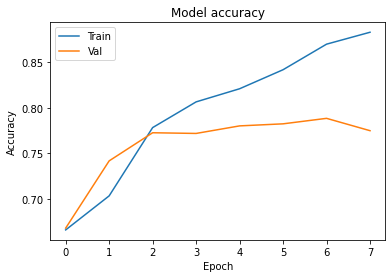

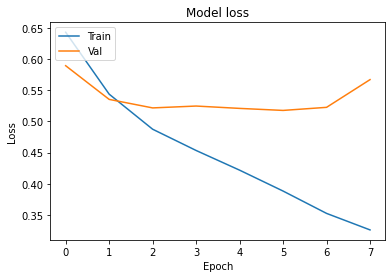

In [0]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

3/3 [==============================] - 1s 266ms/step
[[0.05386436]
 [0.3564797 ]
 [0.02221528]
 ...
 [0.19842783]
 [0.22555141]
 [0.13463804]]


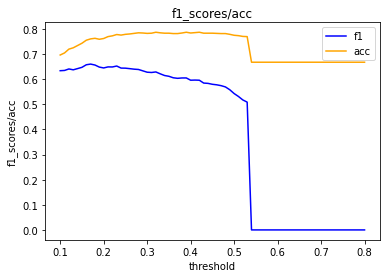

In [0]:
# validation the model(f1-score)
pred_noemb_val_y = model_CNN.predict([val_X], batch_size=512, verbose=1)
print(pred_noemb_val_y)
threshes=[]
f1_scores=[]
accuracy_scores=[]
for thresh in np.arange(0.1, 0.801, 0.01):
    thresh = np.round(thresh, 2)
    threshes.append(thresh)
    # logging.info("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))))
    f1_scores.append(metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int)))
    # logging.info("Accuracy at threshold {0} is {1}".format(thresh, metrics.accuracy_score(val_y, (pred_noemb_val_y>thresh).astype(int))))
    accuracy_scores.append(metrics.accuracy_score(val_y, (pred_noemb_val_y>thresh).astype(int)))

# plot two measures
plt.plot(threshes, f1_scores, color='blue', label='f1')
plt.plot(threshes, accuracy_scores, color='orange', label='acc')
plt.title('f1_scores/acc')
plt.ylabel('f1_scores/acc')
plt.xlabel('threshold')
plt.legend()
plt.show()

CNN visualiazation

In [0]:
class_idx = np.argmax(pred_noemb_val_y[0]) #not needed in this case as only two classes
class_output = model_CNN.output[:, class_idx]
last_conv_layer = model_CNN.get_layer("Conv1")

In [0]:
print(class_idx)
print(class_output)

0
Tensor("strided_slice_2:0", shape=(None,), dtype=float32)


In [0]:
from keras import backend as K 
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads)
iterate = K.function([model_CNN.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([val_X])

In [0]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)#normalise values in the prediction

In [0]:
from IPython.display import HTML
norm_len = max_len/last_conv_layer.output_shape[1] # find the ratio of the text vs the conv layer length
html = ""

if pred_noemb_val_y[0]>0.5:
    pred = 'light'
else:
    pred = 'dark'
    html += "<span><h3>Based on the description, the model believes that this is a {} XXX".format(pred)
    html += "<small><br>Confidence: {:.0f}%<br><br></small></h3></span>".format(abs(((pred_noemb_val_y[0][0]*100)-50)*2))
for j,i in enumerate(tokenizer.sequences_to_texts(val_X)[0].split()):
    html += "<span style='background-color:rgba({},0,150,{})'>{} </span>".format(heatmap[math.floor(j/norm_len)]*255,heatmap[math.floor(j/norm_len)]-0.3,i)
HTML(html)

Credit to \\
https://towardsdatascience.com/viewing-text-through-the-eyes-of-a-machine-db30c744ee17

# Prediction 2
